In [3]:
import sys
import os
import numpy as np
BIN = '../'
sys.path.append(BIN)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import my_matplotlib_style as ms
from scipy import stats
import utils

import hwcounter

import torch
import torch.nn as nn
import torch.utils.data

from torch.utils.data import TensorDataset
from fastai.callbacks.tracker import SaveModelCallback

from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats
from fastai import train as tr

from nn_utils import get_data, RMSELoss
from utils import plot_activations

from nn_utils import AE_basic, AE_bn_LeakyReLU

mpl.rc_file(BIN + 'my_matplotlib_rcparams')

# Load data
train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_train_27D_5_percent.pkl')
test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_test_27D_5_percent.pkl')

#Remove irrelevant columns
#train.pop('JetGhostArea')
#test.pop('JetGhostArea')
#train.pop('BchCorrCell')
#test.pop('BchCorrCell')

# Remove extreme/bad jets
train = utils.filter_jets(train)
test = utils.filter_jets(test)

# Normalize
train_mean = train.mean()
train_std = train.std()

train, test = utils.custom_normalization(train, test)

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=1024)
db = basic_data.DataBunch(train_dl, valid_dl)

module_name = 'AE_bn_LeakyReLU'
module = AE_bn_LeakyReLU
grid_search_folder = "AE_bn_LeakyReLU_AOD_grid_search_custom_normalization_1500epochs/"

loss_func = nn.MSELoss()

#The folder to analyse
model_folder_name = "AE_27_200_200_200_18_200_200_200_27"

plt.close('all')

latentsize = []
avgcyclesperjet = []

#Just alter this if you want to iterate through every model
#for model_folder in [x for x in os.scandir(grid_search_folder) if x.name == model_folder_name]:
for model_folder in os.scandir(grid_search_folder):
    if model_folder.is_dir():
        for train_folder in os.scandir(grid_search_folder + model_folder.name):
            if train_folder.is_dir() and train_folder.name == 'models':
                plt.close('all')

                #Find the best model
                for f in os.scandir(grid_search_folder + model_folder.name + '/' + train_folder.name + '/'):
                    if f.name[:4] == "best":
                        saved_model_fname = f.name[:-4]
                        print(model_folder.name + " " + f.name[:-4])

                #Load model
                nodes = model_folder.name.split('AE_')[1].split('_')
                latentsize.append(int(nodes[4]))
                nodes = [int(x) for x in nodes]
                model = module(nodes)
                learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, true_wd=True)
                learn.model_dir = grid_search_folder + model_folder.name + '/' + 'models/'
                learn.load(saved_model_fname)
                #model.load_state_dict(torch.load(path_to_saved_model))
                learn.model.eval()

                idxs = (0, 100000)  # Choose events to compare
                
                repeats = 10
                start = hwcounter.count()
                
                for i in range(0,repeats):
                    # Histograms

                    data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
                    #Note, float conversion
                    pred = model(data.float()).detach().numpy()
                    pred = np.multiply(pred, train_std.values)
                    pred = np.add(pred, train_mean.values)
                    data = np.multiply(data, train_std.values)
                    data = np.add(data, train_mean.values)
                
                elapsed = hwcounter.count_end() - start
                print("Test data shape: " + str(data.shape))
                print("Average elapsed cycles: " + str(elapsed/repeats))
                print("Average elapsed cycles per jet: " + str(elapsed/data.shape[0]/repeats ))
                avgcyclesperjet.append(elapsed/data.shape[0]/repeats)




AE_27_200_200_200_18_200_200_200_27 best_AE_bn_LeakyReLU_bs4096_lr1e-02_wd1e-02
Test data shape: torch.Size([100000, 27])
Average elapsed cycles: 4607060462.0
Average elapsed cycles per jet: 46070.60462
AE_27_200_200_200_16_200_200_200_27 best_AE_bn_LeakyReLU_bs4096_lr3e-02_wd1e-04
Test data shape: torch.Size([100000, 27])
Average elapsed cycles: 4258369311.6
Average elapsed cycles per jet: 42583.693115999995
AE_27_200_200_200_14_200_200_200_27 best_AE_bn_LeakyReLU_bs4096_lr1e-02_wd1e-02
Test data shape: torch.Size([100000, 27])
Average elapsed cycles: 3827810773.2
Average elapsed cycles per jet: 38278.107732
AE_27_200_200_200_12_200_200_200_27 best_AE_bn_LeakyReLU_bs4096_lr1e-03_wd1e-01
Test data shape: torch.Size([100000, 27])
Average elapsed cycles: 3826531194.3
Average elapsed cycles per jet: 38265.311943
AE_27_200_200_200_20_200_200_200_27 best_AE_bn_LeakyReLU_bs4096_lr1e-02_wd1e-02
Test data shape: torch.Size([100000, 27])
Average elapsed cycles: 3798657312.3
Average elapsed cycl

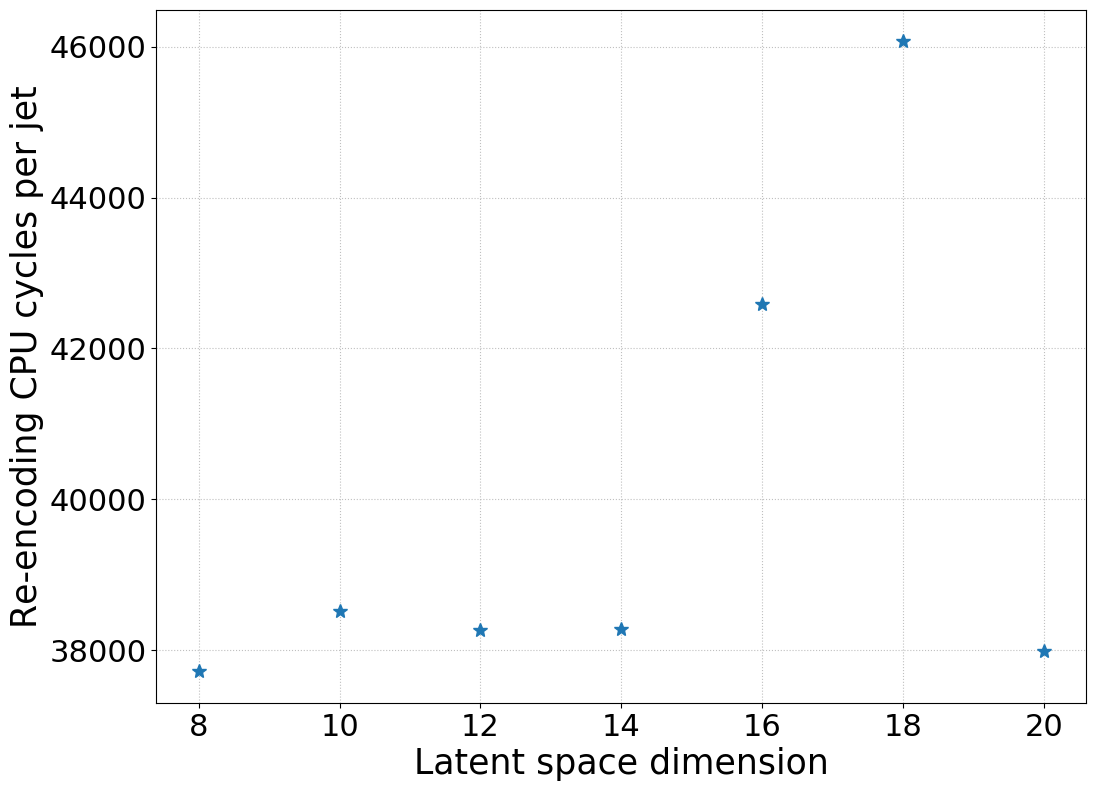

In [4]:
plt.xlabel("Latent space dimension")
plt.ylabel("Re-encoding CPU cycles per jet")
plt.plot(latentsize,avgcyclesperjet,'*')